# keras와 Pytorch비교
* make date : 2024-03-22
* 신재호

# keras MNIST분류

In [ ]:
from keras.datasets import mnist
from keras.utils import to_categorical, Sequence
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

(X_train, y_train), (X_val, y_val) = mnist.load_data()

In [ ]:
X_train = X_train.reshape(-1,28,28,1)/255.
X_val = X_val.reshape(-1,28,28,1)/255.

y_train = to_categorical(y_train)
y_val = to_categorical(y_val)

In [ ]:
class DataLoader(Sequence):
  def __init__(self, batch_size, X, y):
    self.batch_size = batch_size
    self.X = X
    self.y = y

  def __getitem__(self, idx):
    start, end = idx * self.batch_size, (idx + 1) * self.batch_size
    return self.X[start:end], self.y[start:end]

  def __len__(self):
    return math.ceil(len(self.y)/self.batch_size)

def Simple_CNN():
  model = Sequential()
  model.add(Conv2D(32,(2,2),activation="relu",input_shape=(28,28,1)))
  model.add(BatchNormalization())
  model.add(Conv2D(64,(2,2),activation="relu"))
  model.add(BatchNormalization())
  model.add(Flatten())
  model.add(Dense(128,activation = 'relu'))
  model.add(Dense(10, activation = 'softmax'))
  return model

In [ ]:
train_loader = DataLoader(32, X_train, y_train)
val_loader = DataLoader(32, X_val, y_val)


model = Simple_CNN()
model.compile(optimizer = 'SGD', loss = 'categorical_crossentropy', metrics = ['acc'])
model_checkpoint = ModelCheckpoint(monitor = 'val_loss', save_best_only = True, verbose=1,
                                   filepath = '/content/keras_CNN.h5')
history = model.fit(train_loader, validation_data = val_loader, epochs = 10, callbacks = [model_checkpoint])

Epoch 1/10
1871/1875 [============================>.] - ETA: 0s - loss: 0.1286 - acc: 0.9615
Epoch 1: val_loss improved from inf to 0.06951, saving model to /content/keras_CNN.h5
1875/1875 [==============================] - 12s 6ms/step - loss: 0.1285 - acc: 0.9615 - val_loss: 0.0695 - val_acc: 0.9768
Epoch 2/10
1868/1875 [============================>.] - ETA: 0s - loss: 0.0254 - acc: 0.9925
Epoch 2: val_loss improved from 0.06951 to 0.05502, saving model to /content/keras_CNN.h5
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0253 - acc: 0.9925 - val_loss: 0.0550 - val_acc: 0.9833
Epoch 3/10
1874/1875 [============================>.] - ETA: 0s - loss: 0.0080 - acc: 0.9981
Epoch 3: val_loss improved from 0.05502 to 0.04239, saving model to /content/keras_CNN.h5
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0080 - acc: 0.9981 - val_loss: 0.0424 - val_acc: 0.9862
Epoch 4/10
1869/1875 [============================>.] - ETA: 0s - loss: 0.0029 - ac

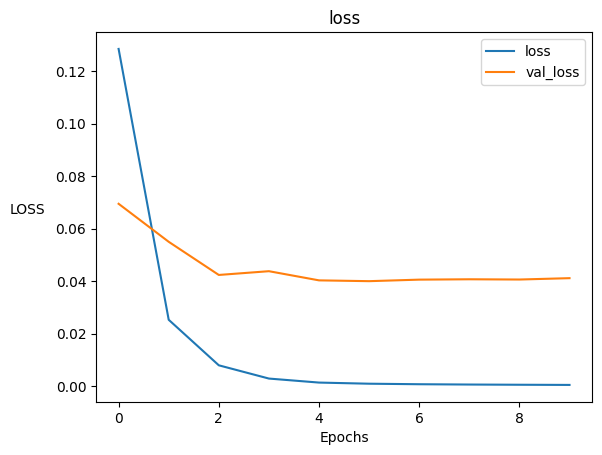

In [ ]:
plt.plot(history.history['loss'], label = 'loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.legend()
plt.title('loss')
plt.xlabel('Epochs')
plt.ylabel('LOSS', rotation = 360, labelpad = 20)
plt.show()

# Pytorch MNIST 분류

In [ ]:
import torch
from torch import nn
from torchvision import transforms, datasets

device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
import torch
from torchvision import datasets, transforms

class CustomMNIST(datasets.MNIST):
    def __init__(self, root, train=True, transform=None, target_transform=None, download=False):
        super().__init__(root=root, train=train, transform=transform, target_transform=target_transform, download=download)

    def __getitem__(self, index):
        img, target = super().__getitem__(index)
        return img, target

# 데이터셋 불러오기
train_dataset = CustomMNIST(root="./data/MNIST", train=True, download=True, transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x / 255.0)
]))
val_dataset = CustomMNIST(root="./data/MNIST", train=False, transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x / 255.0)
]))

# 데이터로더 생성
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=32, drop_last=True)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=32, drop_last=True)

In [ ]:
class Simple_CNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Sequential(
        nn.Conv2d(in_channels = 1, out_channels = 32, kernel_size = 2),
        nn.ReLU(),
        nn.BatchNorm2d(32)
    )
    self.conv2 = nn.Sequential(
        nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 2),
        nn.ReLU(),
        nn.BatchNorm2d(64)
    )
    self.dense1 = nn.Sequential(
        nn.Linear(in_features = 64 * 26 * 26, out_features = 128),
        nn.ReLU()
    )
    # 파이토치의 nn.CrossEntropy는 softmax가 합쳐저 있으므로 따로 softmax층을 선언할 필요없음!!
    self.dense2 = nn.Linear(in_features = 128, out_features = 10)

  def forward(self, x):
    out = self.conv1(x)
    out = self.conv2(out)
    out = out.reshape(out.size(0), -1)
    out = self.dense1(out)
    out = self.dense2(out)
    return out

In [ ]:
def train(model, loader, criterion, optimizer):
  '''
  학습을 위한 함수
  '''
  model.train()
  train_loss = 0.

  for X, y in loader:

    #X = X.view(32,1,28,28)
    X = X.to(device)
    y = y.to(device)

    y_hat = model(X)
    loss = criterion(y_hat, y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    train_loss += loss.item()
  train_loss  = train_loss / len(loader)

  return train_loss

def val(model, loader, criterion):
  '''
  검증을 위한 함수
  '''
  model.eval()
  val_loss = 0.

  for X, y in loader:

    #X = X.view(32,1,28,28)
    X = X.to(device)
    y = y.to(device)

    y_hat = model(X)
    loss = criterion(y_hat, y)

    val_loss += loss.item()
  val_loss  = val_loss / len(loader)

  return val_loss

In [ ]:
train_loss_list = []
val_loss_list = []

model = Simple_CNN().to(device)

epochs = 10
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01)
criterion = nn.CrossEntropyLoss().to(device)

In [ ]:
st_loss = 1000

for epoch in range(epochs):
  print(f'########### epoch : {epoch + 1} ###########')
  train_loss = train(model, train_loader, criterion, optimizer)
  val_loss = val(model, val_loader, criterion)
  train_loss_list.append(train_loss)
  val_loss_list.append(val_loss)
  if val_loss < st_loss:
    print(f'* train_loss = {train_loss}')
    print(f'* val_loss가 향상되었습니다. {st_loss} ==> {val_loss}')
    st_loss = val_loss
    torch.save(model.state_dict(), '/content/pytorch_CNN.pt')
  else:
    print(f'* train_loss = {train_loss}')
    print(f'* val_loss가 향상되지 않았습니다, val_loss = {val_loss}')

########### epoch : 1 ###########
* train_loss = 0.13105295144335055
* val_loss가 향상되었습니다. 1000 ==> 0.06692975704908559
########### epoch : 2 ###########
* train_loss = 0.03514991371879975
* val_loss가 향상되었습니다. 0.06692975704908559 ==> 0.04835883787843788
########### epoch : 3 ###########
* train_loss = 0.013969629514523936
* val_loss가 향상되었습니다. 0.04835883787843788 ==> 0.0448556376541558
########### epoch : 4 ###########
* train_loss = 0.006104732120387295
* val_loss가 향상되었습니다. 0.0448556376541558 ==> 0.04448472389412053
########### epoch : 5 ###########
* train_loss = 0.003201203266981368
* val_loss가 향상되었습니다. 0.04448472389412053 ==> 0.04447795759140496
########### epoch : 6 ###########
* train_loss = 0.0020442538509858423
* val_loss가 향상되었습니다. 0.04447795759140496 ==> 0.04446311054977496
########### epoch : 7 ###########
* train_loss = 0.0015044091179205377
* val_loss가 향상되었습니다. 0.04446311054977496 ==> 0.04394939324537407
########### epoch : 8 ###########
* train_loss = 0.0011941711406359293
*

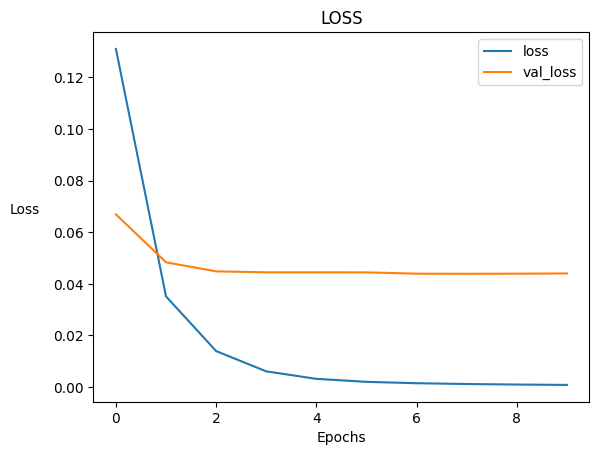

In [ ]:
plt.plot(train_loss_list, label = 'loss')
plt.plot(val_loss_list, label = 'val_loss')
plt.legend()
plt.title('LOSS')
plt.xlabel('Epochs')
plt.ylabel('Loss', rotation = 360, labelpad = 20)
plt.show()